In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [2]:
filepath = '/kaggle/input/playground-series-s3e12'

df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
original = pd.read_csv('/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv')

df_train['is_generated'] = 1
df_test['is_generated'] = 1
original['is_generated'] = 0

original = original.reset_index()
original['id'] = original['index'] + df_test.index[-1] + 1
original = original.drop(columns = ['index']).set_index('id')

target_col = 'target'

## Simple EDA

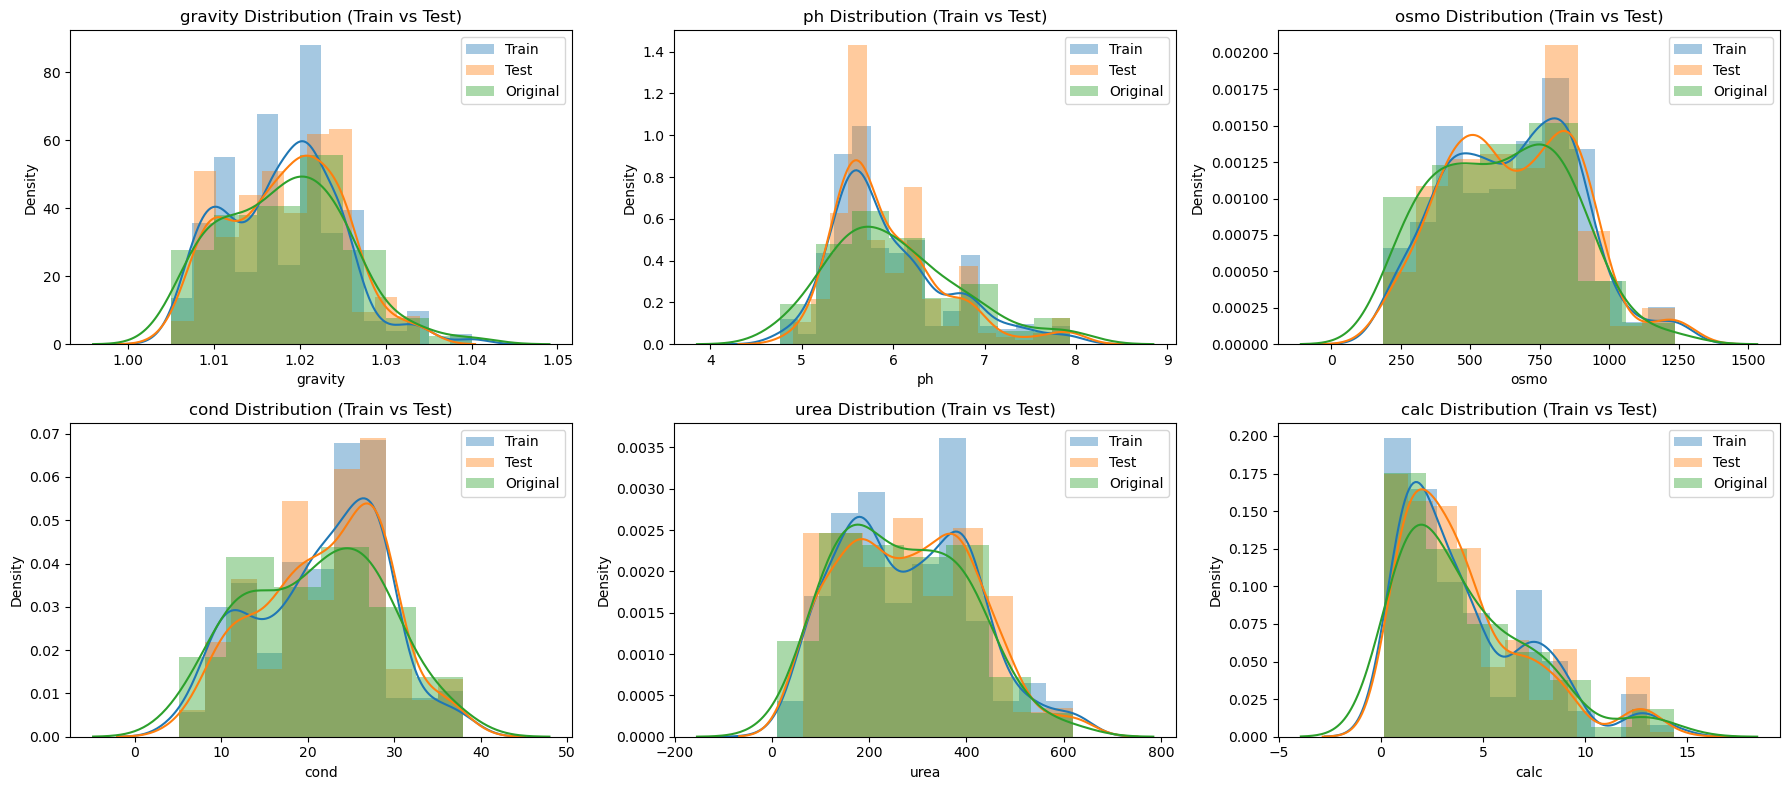

In [3]:
n_cols = 3
n_rows = (len(df_test.columns) - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

for i, var_name in enumerate(df_test.columns.tolist()):
    if var_name != 'is_generated':
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()
    
plt.tight_layout()
plt.show()

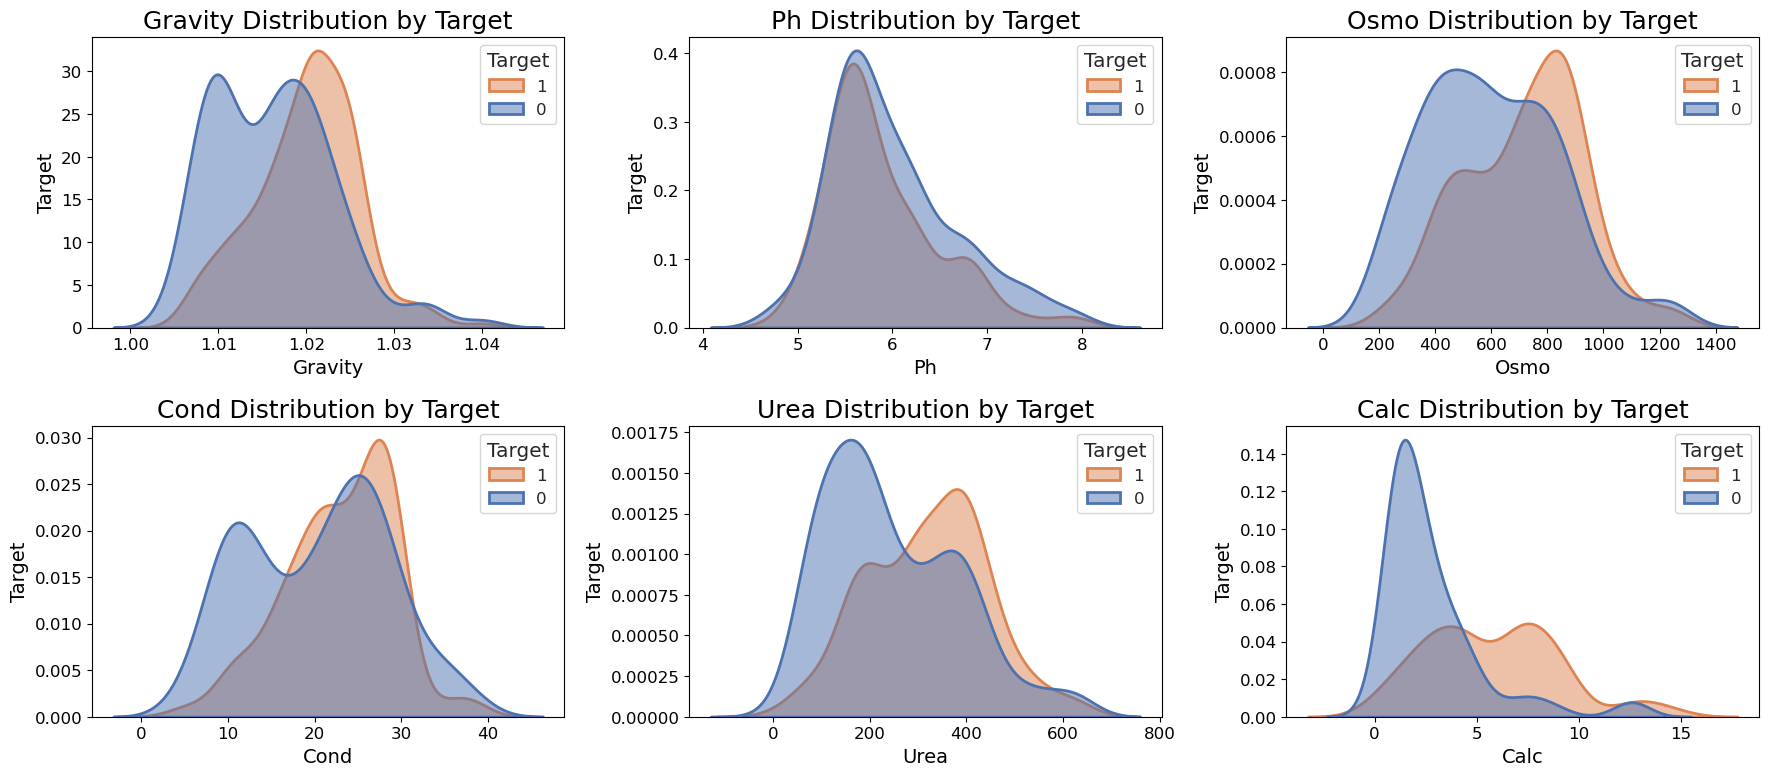

In [4]:
num_cols = 3
num_rows = (len(df_test.columns) - 1) // num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4*num_rows))
sns.set(font_scale=1.2, style='whitegrid')

for i, col_name in enumerate(df_test.columns):
    if col_name != 'is_generated':
        ax = axes[i // num_cols, i % num_cols]
        sns.kdeplot(data=df_train, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)
        # sns.kdeplot(data=original, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

        ax.set_title(f'{col_name.title()} Distribution by {target_col.title()}', fontsize=18)
        ax.set_xlabel(col_name.title(), fontsize=14)
        ax.set_ylabel(target_col.title(), fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend([1, 0], title=target_col.title(), fontsize=12)

plt.tight_layout()
plt.show()

<AxesSubplot:>

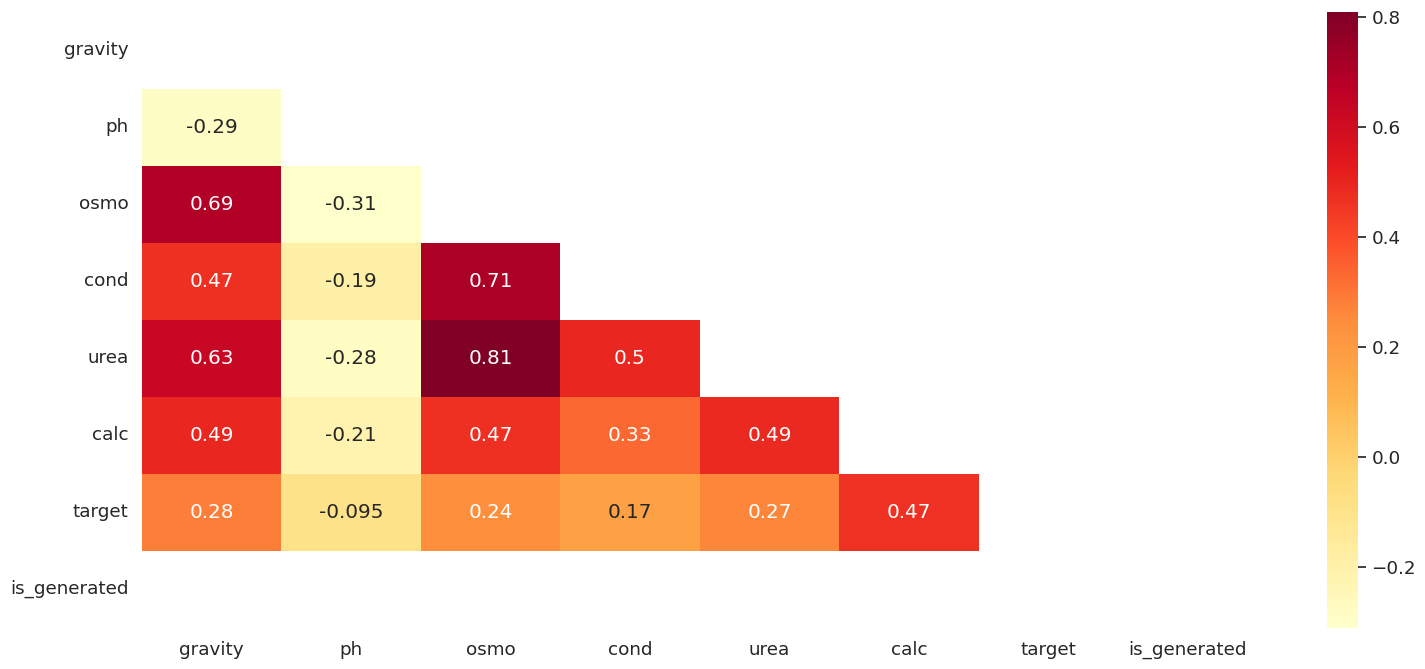

In [5]:
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(df_train.corr()))
sns.heatmap(df_train.corr(),cmap='YlOrRd',annot=True,mask=mask)

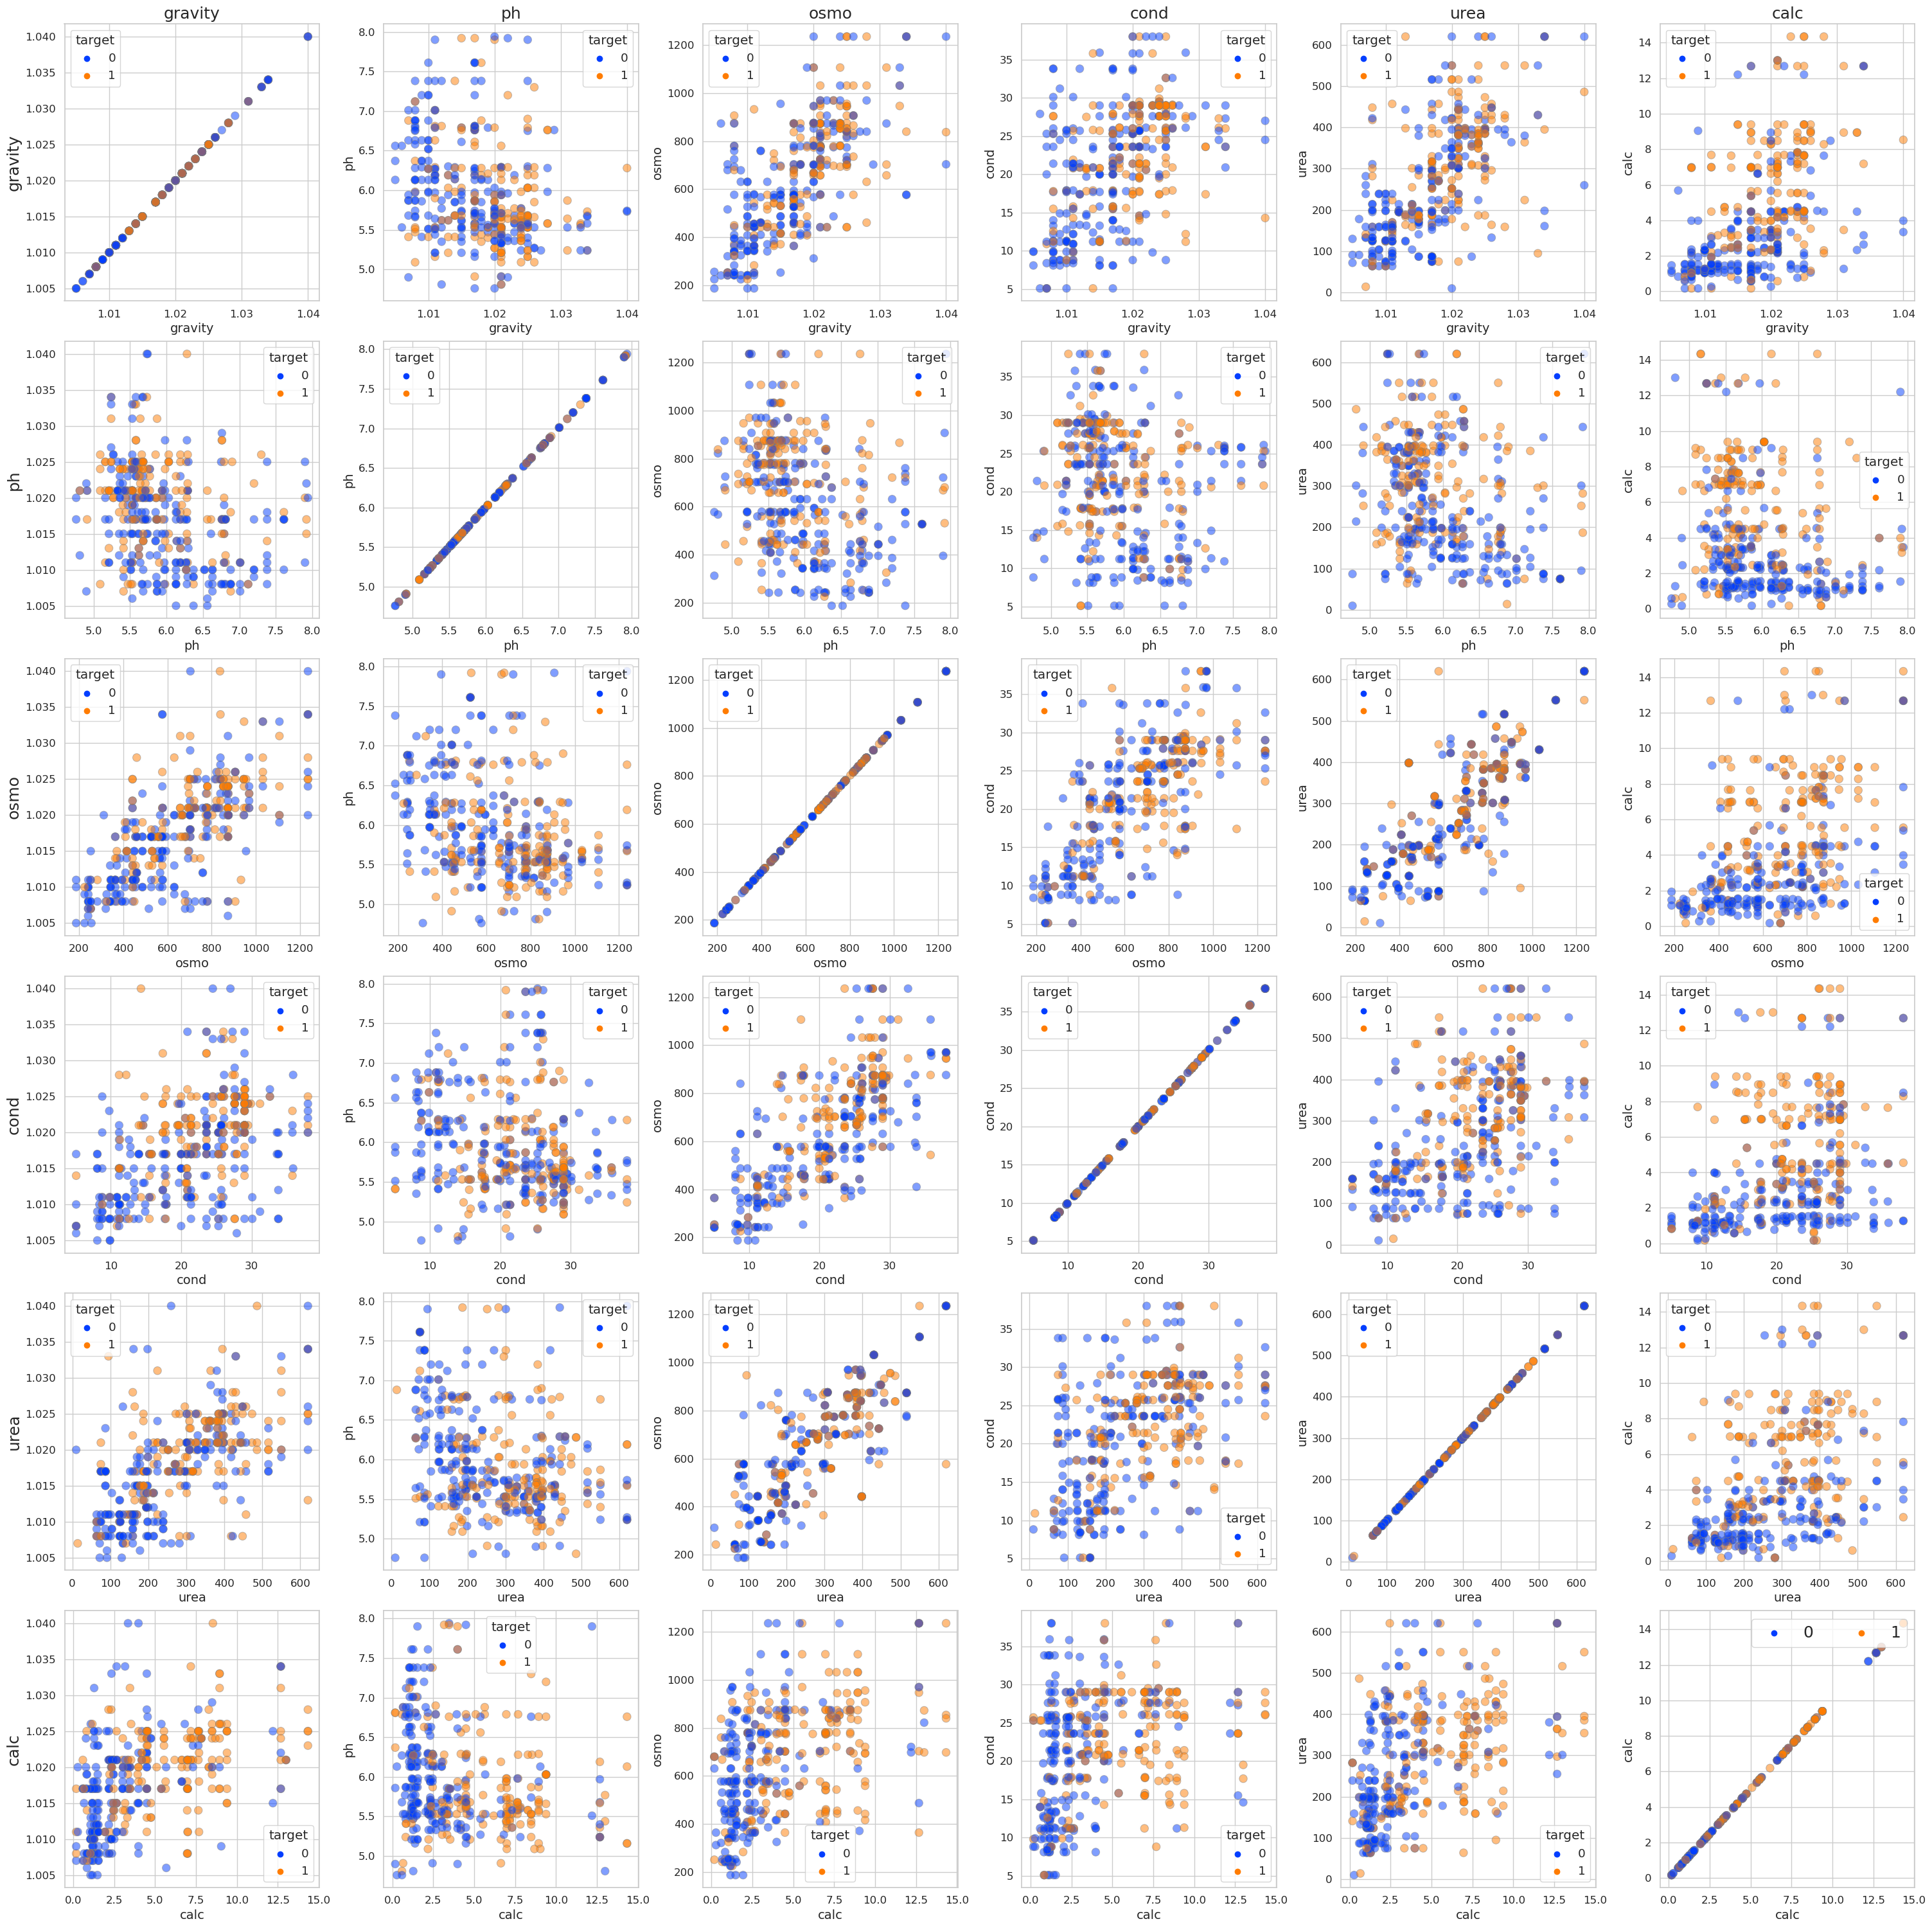

In [6]:
def plot_scatter_matrix(df, target_col, drop_cols=[], size=30):
    # sns.pairplot()
    
    sns.set_style('whitegrid')
    cols = df.columns.drop([target_col] + drop_cols)
    fig, axes = plt.subplots(len(cols), len(cols), figsize=(size, size), sharex=False, sharey=False)

    for i, col in enumerate(cols):
        for j, col_ in enumerate(cols):
            axes[i,j].set_xlabel(f'{col}', fontsize=14)
            axes[i,j].set_ylabel(f'{col_}', fontsize=14)

            # Plot the scatterplot
            sns.scatterplot(data=df, x=col, y=col_, hue=target_col, ax=axes[i,j],
                            s=80, edgecolor='gray', alpha=0.5, palette='bright')

            axes[i,j].tick_params(axis='both', which='major', labelsize=12)

            if i == 0:
                axes[i,j].set_title(f'{col_}', fontsize=18)
            if j == 0:
                axes[i,j].set_ylabel(f'{col}', fontsize=18)

    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    plt.legend(loc='upper right', ncol=5, fontsize=18)
    plt.show()
    

plot_scatter_matrix(df_train, target_col, drop_cols=['is_generated'])

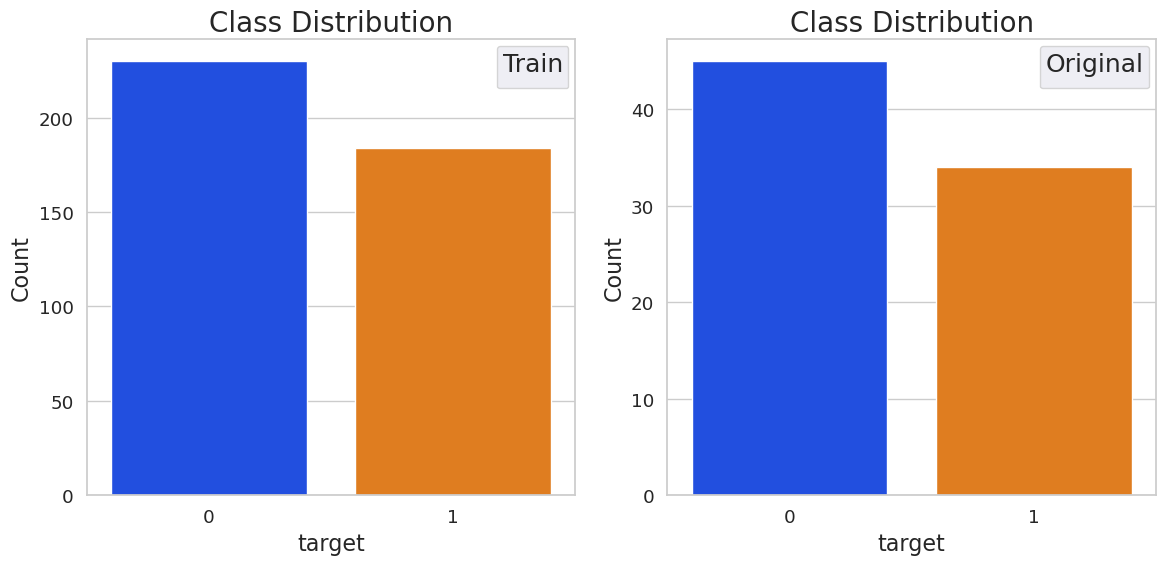

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.set(font_scale=1.5)

for i, (title, df) in enumerate(zip(['Train', 'Original'], [df_train, original])):
    classes = df[target_col].value_counts()
    class_names = classes.index
    class_counts = classes.values
    
    ax = sns.barplot(x=class_names, y=class_counts, palette='bright', ax=axes[i])
    ax.set_xlabel(target_col, fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Class Distribution', fontsize=20)
    ax.legend(title=title, fontsize=10)

plt.tight_layout()
plt.show()

## Pre-Processing
Updated feature engineering.  
kudo to lyasdemir (https://www.kaggle.com/code/tetsutani/ps3e12-eda-ensemble-baseline/comments#2209795)

In [8]:
def create_new_features(data):
    # Ion product of calcium and urea
    data["ion_product"] = data["calc"] * data["urea"]

    # Calcium-to-urea ratio
    data["calcium_to_urea_ratio"] = data["calc"] / data["urea"]

    # Electrolyte balance
    data["electrolyte_balance"] = data["cond"] / (10 ** (-data["ph"]))

    # Osmolality-to-specific gravity ratio
    data["osmolality_to_sg_ratio"] = data["osmo"] / data["gravity"]
    
    ## Add Feature engineering part 
    # The product of osmolarity and density is created as a new property
    data['osmo_density'] = data['osmo'] * data['gravity']
    
    # Converting pH column to categorical variable
    data['pH_cat'] = pd.cut(data['ph'], bins=[0, 4.5, 6.5, 8.5, 14], labels=['sangat acidic', 'acidic', 'neutral', 'basic'])
    dummies = pd.get_dummies(data['pH_cat'])
    data = pd.concat([data, dummies], axis=1)
    
    # Deleting columns using dummy variables.
    data.drop(['pH_cat', 'sangat acidic' , 'basic','neutral','ph'], axis=1, inplace=True)
    
    return data

In [9]:
# Concatenate train and original dataframes, and prepare train and test sets
df_train = pd.concat([df_train, original])
X_train = df_train.drop([f'{target_col}'],axis=1).reset_index(drop=True)
y_train = df_train[f'{target_col}'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

# Create Feature
X_train = create_new_features(X_train)
X_test = create_new_features(X_test)

# StandardScaler
categorical_columns = ['is_generated', 'acidic']
numeric_columns = [_ for _ in X_train.columns if _ not in categorical_columns]
sc = StandardScaler()
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# Delete the train and test dataframes to free up memory
del df_train, df_test

X_train shape :(493, 12) , y_train shape :(493,)
X_test shape :(276, 12)


In [10]:
X_train.head(5)

gravity      osmo      cond      urea      calc  is_generated  \
0 -0.729733 -0.860744 -0.863459 -1.127468 -0.829285             1   
1  1.046851  0.245256  0.298749  0.866173  0.019100             1   
2 -1.321927 -1.167021  0.417612 -0.869033  1.529411             1   
3  0.454656 -0.864998 -0.071044  0.895708  0.780470             1   
4  0.454656  0.972664 -0.467251  0.799718 -0.593105             1   

   ion_product  calcium_to_urea_ratio  electrolyte_balance  \
0    -0.811730              -0.348577            -0.231793   
1     0.202748              -0.436926            -0.287836   
2     0.057842               3.330822            -0.198397   
3     0.888568               0.055908            -0.301809   
4    -0.347715              -0.833600            -0.287495   

   osmolality_to_sg_ratio  osmo_density  acidic  
0               -0.858160     -0.863078       1  
1                0.232315      0.257805       1  
2               -1.163639     -1.169962       1  
3               -0.877492     -0.852674       1  
4                0.978943      0.966166       1

## Define Model

In [11]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5):
        self.n_splits = n_splits
        self.kfold = kfold

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            X_train, X_val = X.iloc[:373], X.iloc[373:]
            y_train, y_val = y.iloc[:373], y.iloc[373:]
            yield X_train, X_val, y_train, y_val

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.05,
            'max_depth': 7,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'binary',
            'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 7,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'Logloss',
            'loss_function': 'Logloss',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        
        models = {
            'xgb': xgb.XGBClassifier(**xgb_params),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'cat': CatBoostClassifier(**cb_params),
            'lr': LogisticRegression(max_iter=500, random_state=self.random_state),
            'rf': RandomForestClassifier(n_estimators=1000, random_state=self.random_state),
            'hgb': HistGradientBoostingClassifier(max_iter=2000, random_state=self.random_state),
            'gbdt': GradientBoostingClassifier(n_estimators=1000, random_state=self.random_state),
            'svc': SVC(gamma="auto", probability=True),
            'knn': KNeighborsClassifier(n_neighbors=5),
            'mlp': MLPClassifier(random_state=self.random_state, max_iter=1000),
            #'brf': BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=self.random_state),
            #'gpc': GaussianProcessClassifier(1.0 * RBF(1.0), random_state=self.random_state),
        }
        
        return models

## Optimizer

In [12]:
class OptunaWeights:
    def __init__(self, random_state):
        self.study = None
        self.weights = None
        self.random_state = random_state

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the AUC score for the weighted prediction
        score = roc_auc_score(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds, n_trials=2000):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds, n_trials=2000):
        self.fit(y_true, y_preds, n_trials=n_trials)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

## Train Model

In [13]:
kfold = True
n_splits = 1 if not kfold else 10
random_state = 2023
random_state_list = [2140] # used by split_data [71]
n_estimators = 9999 # 9999
early_stopping_rounds = 200
verbose = False
device = 'cpu'

splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[]}

    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if name in ['xgb', 'lgb', 'cat']:
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
            trained_models[f'{name}'].append(deepcopy(model))
        else:
            model.fit(X_train_, y_train_)
        
        test_pred = model.predict_proba(X_test)[:, 1]
        y_val_pred = model.predict_proba(X_val)[:, 1]

        score = roc_auc_score(y_val, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] AUC score: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = roc_auc_score(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] AUC score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    
    gc.collect()

xgb [FOLD-0 SEED-2140] AUC score: 0.83604
lgb [FOLD-0 SEED-2140] AUC score: 0.82143
cat [FOLD-0 SEED-2140] AUC score: 0.83279
lr [FOLD-0 SEED-2140] AUC score: 0.82305
rf [FOLD-0 SEED-2140] AUC score: 0.83442
hgb [FOLD-0 SEED-2140] AUC score: 0.82630
gbdt [FOLD-0 SEED-2140] AUC score: 0.76948
svc [FOLD-0 SEED-2140] AUC score: 0.84091
knn [FOLD-0 SEED-2140] AUC score: 0.81737
mlp [FOLD-0 SEED-2140] AUC score: 0.77597
Ensemble [FOLD-0 SEED-2140] AUC score 0.86039
xgb [FOLD-1 SEED-2140] AUC score: 0.82792
lgb [FOLD-1 SEED-2140] AUC score: 0.81656
cat [FOLD-1 SEED-2140] AUC score: 0.83279
lr [FOLD-1 SEED-2140] AUC score: 0.79058
rf [FOLD-1 SEED-2140] AUC score: 0.82630
hgb [FOLD-1 SEED-2140] AUC score: 0.73214
gbdt [FOLD-1 SEED-2140] AUC score: 0.70292
svc [FOLD-1 SEED-2140] AUC score: 0.77110
knn [FOLD-1 SEED-2140] AUC score: 0.72727
mlp [FOLD-1 SEED-2140] AUC score: 0.74188
Ensemble [FOLD-1 SEED-2140] AUC score 0.83604
xgb [FOLD-2 SEED-2140] AUC score: 0.84740
lgb [FOLD-2 SEED-2140] AUC s

In [14]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble Accuracy score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

Ensemble Accuracy score 0.86008 ± 0.03721
--- Model Weights ---
xgb: 0.38238 ± 0.25557
lgb: 0.59239 ± 0.29740
cat: 0.69213 ± 0.24800
lr: 0.40923 ± 0.25045
rf: 0.49146 ± 0.31361
hgb: 0.21778 ± 0.24365
gbdt: 0.41699 ± 0.34825
svc: 0.40316 ± 0.27722
knn: 0.40300 ± 0.28531
mlp: 0.22903 ± 0.30138


## Visualize Feature importance (XGBoost, LightGBM, Catboost)

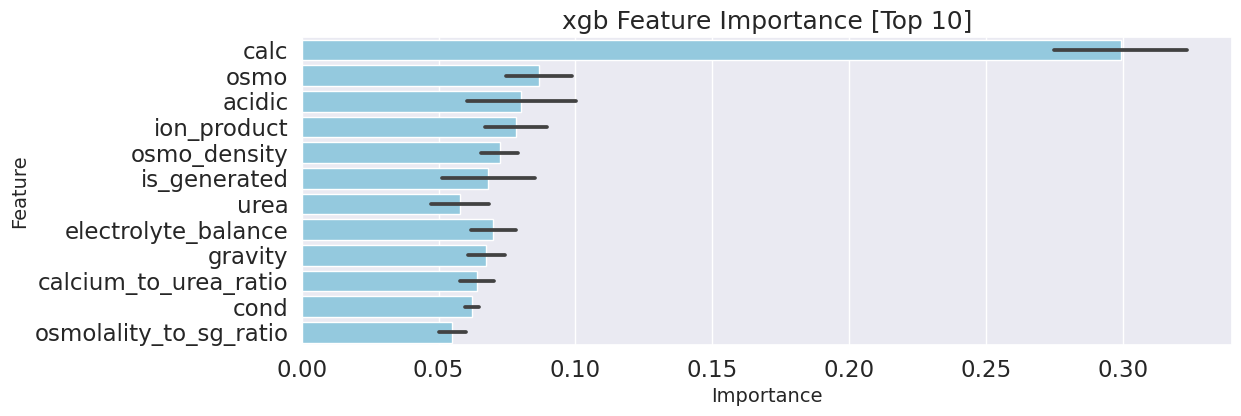

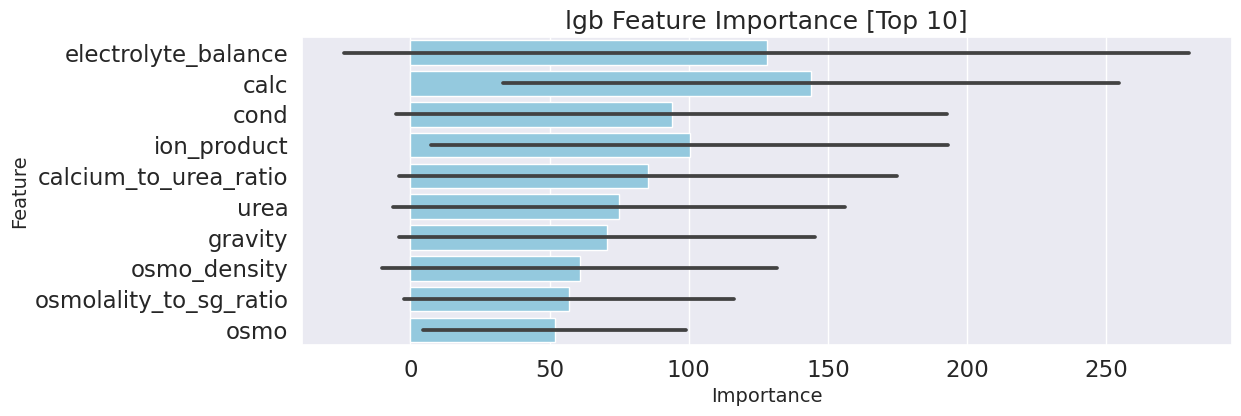

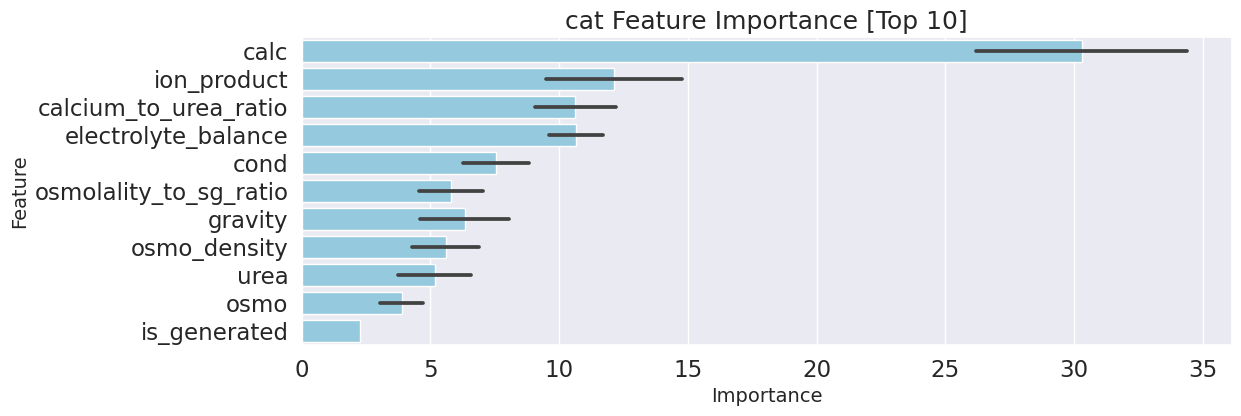

In [15]:
def visualize_importance(models, feature_cols, title, top=10):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(top)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
        
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(12, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance, color='skyblue', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance [Top {top}]', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
for name, models in trained_models.items():
    visualize_importance(models, list(X_train.columns), name)

## Make Submission

In [16]:
sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
sub[f'{target_col}'] = test_predss
sub.to_csv('submission.csv', index=False)
sub

id    target
0    414  0.193049
1    415  0.589762
2    416  0.887547
3    417  0.378925
4    418  0.312473
..   ...       ...
271  685  0.854258
272  686  0.099649
273  687  0.679573
274  688  0.114146
275  689  0.359582

[276 rows x 2 columns]

<AxesSubplot:ylabel='Count'>

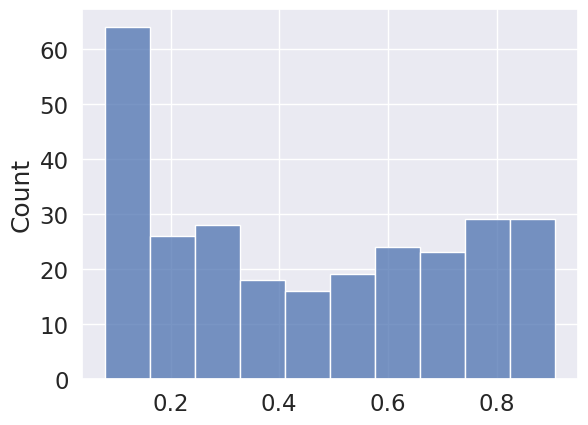

In [17]:
sns.histplot(test_predss)